In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

In [3]:
dataframe = pd.read_excel("fitur_combined.xlsx")
dataframe

,HR,SDNN,RMSSD,SDSD,pNN50,LF,HF,LF/HF,SD1,SD2,SD_ratio,Label
0,66.258988,61.227073,67.783226,65.158415,2.446483,0.055664,0.356445,0.263221,47.929862,72.003950,1.502277,1
1,64.446686,55.173210,58.302508,56.017323,0.943396,0.061523,0.308594,0.270054,41.226092,66.227144,1.606438,1
2,62.692141,99.537279,79.573600,75.421263,3.571429,0.042969,0.290039,0.286273,56.264081,128.622281,2.286046,1
3,63.433824,92.245610,64.134624,60.074981,4.487179,0.056641,0.389648,0.316059,45.349569,121.406513,2.677126,1
4,62.803729,58.825938,82.869466,79.547163,2.258065,0.047852,0.297852,0.333677,58.597402,58.808881,1.003609,1
...,...,...,...,...,...,...,...,...,...,...,...,...
375,77.975022,115.369311,47.334256,36.668310,18.783069,0.041992,0.237305,1.660196,33.469633,159.627078,4.769311,0
376,61.620302,129.153809,107.123572,97.890381,20.469799,0.061523,0.225586,0.217286,75.747572,166.099565,2.192804,0
377,79.215083,121.597106,57.423703,47.552360,16.492147,0.066406,0.249023,3.201225,40.600369,166.697921,4.105823,0
378,69.334370,137.593830,121.752307,112.744990,13.636364,0.085938,0.200195,1.629231,86.090591,174.288084,2.024473,0


In [13]:
# X = dataframe[["SDNN", "SD2", "RMSSD", "SD1", "SDSD", "pNN50", "LF", "HR"]]
X = dataframe[["SDNN", "SD2", "RMSSD", "SD1", "SDSD", "pNN50"]]
num_feature = len(X.columns)

y = dataframe["Label"]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

In [38]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=64, input_shape=(num_feature,), activation="relu"),
        tf.keras.layers.Dense(units=512, activation="relu"),
        tf.keras.layers.Dense(units=256, activation="relu"),
        tf.keras.layers.Dense(units=128, activation="relu"),
        tf.keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

c:\Users\ASUS\anaconda3\envs\cuda-env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


history = model.fit(X_train, y_train, epochs=1000, batch_size=16, validation_split=0.2)

Epoch 1/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5736 - loss: 0.6924 - val_accuracy: 0.6232 - val_loss: 0.6395
Epoch 2/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5622 - loss: 0.6376 - val_accuracy: 0.6667 - val_loss: 0.6297
Epoch 3/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6588 - loss: 0.6388 - val_accuracy: 0.6667 - val_loss: 0.6223
Epoch 4/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6532 - loss: 0.6207 - val_accuracy: 0.6377 - val_loss: 0.6254
Epoch 5/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6886 - loss: 0.6104 - val_accuracy: 0.6957 - val_loss: 0.6149
Epoch 6/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6775 - loss: 0.6070 - val_accuracy: 0.6812 - val_loss: 0.6163
Epoch 7/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7007 - loss: 0.6032 - val_accuracy: 0.7101 - val_loss: 0.6131
Epoch 8/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6350 - loss: 0.6155 - val_accuracy: 0

KeyboardInterrupt: 

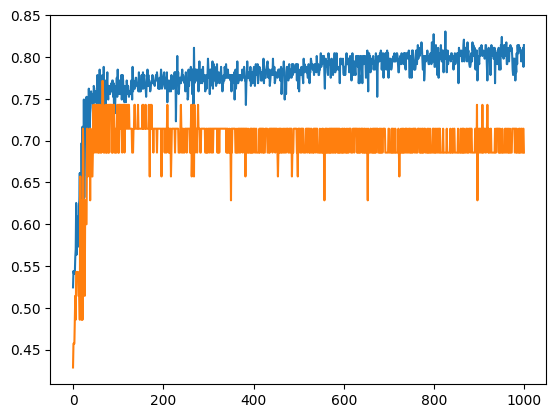

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print(f"Accuracy: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7900 - loss: 0.4748
Loss: 0.49958109855651855
Accuracy: 0.7632


In [ ]:
X_test

,SDNN,SD2,RMSSD,SD1,SDSD,pNN50
65,76.288024,101.258976,52.642465,37.223823,37.733410,22.023810
278,44.239326,58.097926,29.975268,21.194897,18.660397,9.666667
118,110.097056,146.762739,73.006395,51.622786,55.790010,35.099338
101,74.531895,98.603486,51.567514,36.462148,40.568277,21.408451
379,141.728653,189.431300,91.206233,64.491186,79.664144,23.076923
86,61.651962,83.325102,35.916997,25.397143,21.710351,15.950920
122,118.135126,156.533289,82.317829,58.207288,67.920725,25.474255
293,60.231996,64.470091,78.694647,55.645446,71.410919,12.987013
70,55.980765,75.399880,28.986631,20.488618,18.104162,6.514658
267,45.119479,54.182649,47.297682,33.444300,31.548476,20.875421


In [ ]:
prediction = model.predict(X_test)
predicted_labels = (prediction > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Text(113.9222222222222, 0.5, 'predicted class')

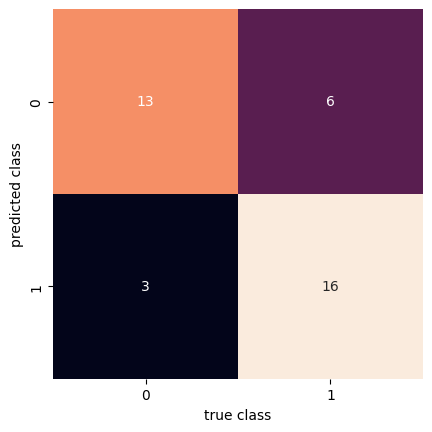

In [ ]:
conmat = confusion_matrix(y_test, predicted_labels)
sns.heatmap(conmat.T, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("true class")
plt.ylabel("predicted class")